# Using non-normalized fpkm values from RNA-seq data to predict Alzheimer's 

# 1. Data input

In [1]:
%matplotlib inline
import pymysql as mdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#connect to mysql db
con = mdb.connect('localhost', 'root', '', 'RNAseq1') #host, user, password, #database

## 1.1 ID Key file

In [3]:
#connect to IDKey
with con:
    cur = con.cursor()
    cur.execute("SELECT * FROM IDKey;")
    rows = cur.fetchall()

In [4]:
colnames = tuple([desc[0] for desc in cur.description])
idkey = pd.DataFrame(list(rows),columns=colnames)
idkey = idkey.set_index(idkey.projid)
idkey = idkey.drop(['projid', 'ind'], axis=1)
#idkey.head()

In [5]:
#get samples with mrna data
mrnaids = idkey.loc[idkey['mrna_data']==1,'mrna_id']
len(mrnaids)

649

## 1.2 Clinical data

In [6]:
#get relevant clinical information
#connect to Clinical data
with con:
    cur = con.cursor()
    cur.execute("SELECT * FROM Clinical;")
    rows = cur.fetchall()

In [7]:
colnames = tuple([desc[0] for desc in cur.description])
clin = pd.DataFrame(list(rows),columns=colnames)
clin = clin.set_index(clin.projid)
clin = clin.drop(['projid', 'ind'], axis=1)
#clin.head()

I have 640 samples in the RNA-seq dataset

projid 82317494 has three different rna_seq IDs (492_120515_0,492_120515_6,492_120515_7)
projid 21274866 has a single rna_seq ID (587_120522_3) but 10 different miRNA IDs in the IDkey file

All three samples look okay in the normalized datased. I'll just remove 492_120515_0 and 492_120515_7

## 1.3 RNA-seq data

In [8]:
#import time
#t0 = time.time()
with con:
    cur = con.cursor()
    cur.execute("SELECT * FROM rnaseq;")
    rows = cur.fetchall()
#print "time taken:", tinme.time()-t0

In [9]:
colnames = tuple([desc[0] for desc in cur.description])
mrna = pd.DataFrame(list(rows),columns=colnames)
mrna = mrna.set_index(mrna.gene_id)
mrna = mrna.drop(['gene_id','492_120515_0','492_120515_7'], axis=1) # drop duplicated individuals
#mrna.head()

## 1.4 Map sample IDs across datasets

In [10]:
#print clinical variations with matched order
mrnaclin = clin[clin.index.isin(list(mrnaids.index))]
# remove samples with cogdx values 0,3,5,6
mrnaclin = mrnaclin.loc[mrnaclin['cogdx'].isin([1,2,4])]
mrnaclin = pd.DataFrame.sort_index(mrnaclin)

In [11]:
# the RNA-seq IDs in batch2 don't have batch numbers in the clinical table
mrna.columns = pd.Series(mrna.columns).str.replace('_7', '')
mrna.columns = pd.Series(mrna.columns).str.replace('_8', '')

In [12]:
# get projids
tmp = dict(zip(idkey.mrna_id, idkey.index))
tmp = dict([(vkey, vdata) for vkey, vdata in tmp.iteritems() if(vkey and vkey != '492_120515_0' and vkey != '492_120515') ])
mrna = pd.DataFrame.rename(mrna,columns=tmp)
#mrna.head()

In [13]:
# drop samples that do not have proper cogdx
mrna = mrna[(list(mrnaclin.index))]

/home/sun-gou/anaconda2/lib/python2.7/site-packages/pandas/core/index.py:812: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.is_unique


In [14]:
# check variance of gene measurements
mrna_var = pd.DataFrame.var(mrna, axis =1)
#pd.Series.hist(mrna_var.loc[(mrna_var > 1) & (mrna_var < 500)], bins=100, log=False, figsize=(10,10))
len(mrna_var.loc[mrna_var == 0])

13198

In [15]:
#keep only genes with non-zero variance
mrna_yesvar = mrna[mrna.index.isin(list(mrna_var.loc[mrna_var != 0].index))]
mrna_yesvar = pd.DataFrame.sort_index(mrna_yesvar.T)

### Lets see how much variation is in this data

# 2. Use all genes with non-zero variance

## 2.1 PCA and LDA

In [16]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X = pd.DataFrame.as_matrix(mrna_yesvar)

y = pd.Series.as_matrix(mrnaclin.cogdx)
y = np.array([0 if x == 1 else x for x in y])
y = np.array([1 if x == 2 else x for x in y])
y = np.array([2 if x == 4 else x for x in y])

target_names = np.array(["control","MCI","AZ"])

In [17]:
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
lda = LDA(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


explained variance ratio (first two components): [ 0.87441389  0.06757712]


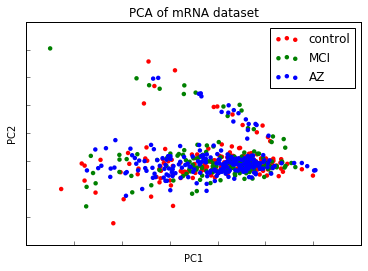

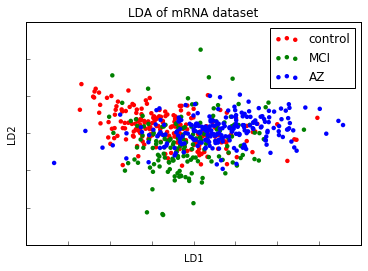

In [18]:
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

fig = plt.figure()
ax = fig.add_subplot(111)
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=c, edgecolor='', label=target_name)
plt.legend()
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of mRNA dataset')
fig.savefig('mRNA_PCA.jpg', bbox_inches='tight', dpi=700)

fig = plt.figure()
ax = fig.add_subplot(111)
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], c=c, edgecolor='', label=target_name)
plt.legend()
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('LDA of mRNA dataset')
fig.savefig('mRNA_LDA.jpg', bbox_inches='tight', dpi=700)

plt.show()

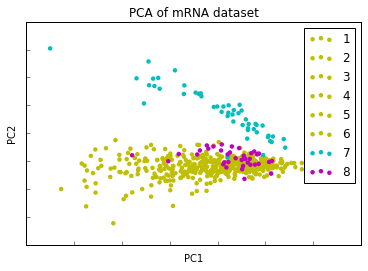

In [19]:
batch = pd.DataFrame.from_csv("RNA_seq.RIN_batch.csv")
batch = batch[batch.index.isin(list(mrnaclin.index))]
batch = pd.DataFrame.sort_index(batch)
y2 = pd.Series.as_matrix(batch.Batch)

batch_names = np.array(["1","2","3","4","5","6","7","8"])
fig = plt.figure()
ax = fig.add_subplot(111)
#plt.figure()
for c, i, batch_name in zip("yyyyyycm", [1, 2, 3, 4, 5, 6, 7, 8], batch_names):
    plt.scatter(X_r[y2 == i, 0], X_r[y2 == i, 1], c=c, edgecolor='', label=batch_name)
plt.legend()
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of mRNA dataset')
fig.savefig('mRNA_PCA.batch.jpg', bbox_inches='tight', dpi=700)

### Now Lets run some prediction models
## 2.2 Prediction without feature selection

### 2.2.1 Set up cross-validation and test set

In [20]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, auc

# controls, MCI, and AZ labels
labels = mrnaclin['cogdx'].values.tolist()
bin_labels = [1 if x == 4 else 0 for x in labels]

# training and test set
(X_train, X_test, y_train, y_test) = train_test_split(mrna_yesvar,bin_labels,test_size=0.2,stratify=labels,random_state=0)

# set up 5X crossvalidation within training set
slo = StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.2, random_state=0)

### 2.2.2 Some positive controls

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.lda import LDA

plate_labels = batch.Batch
batch_labels = [1 if x > 6 else 0 for x in plate_labels]

/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


In [22]:
# logistic regression to predict plate without feature selection
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
cross_validation.cross_val_score(lr, mrna_yesvar, plate_labels, cv=slo, n_jobs = 1, scoring='accuracy')

array([ 0.80645161,  0.8172043 ,  0.75268817,  0.7311828 ,  0.8172043 ])

In [23]:
# logistic regression to predict batch without feature selection
lr = LogisticRegression()
cross_validation.cross_val_score(lr, mrna_yesvar, batch_labels, cv=slo, n_jobs = 1, scoring='accuracy')

array([ 1.        ,  1.        ,  0.98924731,  1.        ,  1.        ])

In [24]:
# run elasticnet to predict batch without feature selection
el = ElasticNet()
cross_validation.cross_val_score(el, mrna_yesvar, batch_labels, cv=slo, n_jobs = 1)

/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


array([ 0.95990022,  0.95226571,  0.95180495,  0.93458958,  0.95118346])

In [25]:
# run random forest to predict plate without feature selection
rf = RandomForestClassifier()
cross_validation.cross_val_score(rf, mrna_yesvar, plate_labels, cv=slo, n_jobs = 1, scoring='accuracy')

array([ 0.65591398,  0.72043011,  0.7311828 ,  0.62365591,  0.69892473])

Great! Works okay. Batch effects are predictable!

### 2.2.3 Now for some real prediction

In [26]:
# logistic regression (multinomial) without feature selection

lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
cross_validation.cross_val_score(lr, mrna_yesvar, labels, cv=slo, n_jobs = 1, scoring='accuracy')

array([ 0.41935484,  0.52688172,  0.47311828,  0.46236559,  0.49462366])

In [27]:
# logistic regression (one-versus-rest) 

lr = LogisticRegression(multi_class='ovr', solver='lbfgs')
cross_validation.cross_val_score(lr, mrna_yesvar, labels, cv=slo, n_jobs = 1, scoring='accuracy')

array([ 0.40860215,  0.47311828,  0.49462366,  0.4516129 ,  0.46236559])

In [28]:
# randomforest (full) without feature selection

rf = RandomForestClassifier()
cross_validation.cross_val_score(rf, mrna_yesvar, labels, cv=slo, n_jobs = 1, scoring='accuracy')

array([ 0.3655914 ,  0.40860215,  0.41935484,  0.47311828,  0.39784946])

None of the multiclass approaches seem to work 

In [30]:
# logistic regression (az vs rest) without feature selection
lr = LogisticRegression()
res1 = cross_validation.cross_val_score(lr, mrna_yesvar, bin_labels, cv=slo, n_jobs = 1, scoring='roc_auc')
lda = LDA()
res2 = cross_validation.cross_val_score(lda, mrna_yesvar, bin_labels, cv=slo, n_jobs = 1, scoring='roc_auc')
el = ElasticNet()
res3 = cross_validation.cross_val_score(el, mrna_yesvar, bin_labels, cv=slo, n_jobs = 1, scoring='roc_auc')
rf = RandomForestClassifier()
res4 = cross_validation.cross_val_score(rf, mrna_yesvar, bin_labels, cv=slo, n_jobs = 1, scoring='roc_auc')

In [31]:
res = [res1, res2, res3, res4]
res

[array([ 0.62192623,  0.75185529,  0.7037037 ,  0.73117761,  0.65852443]),
 array([ 0.54969262,  0.74025974,  0.60493827,  0.68822394,  0.610668  ]),
 array([ 0.62346311,  0.74489796,  0.74548908,  0.79874517,  0.67996012]),
 array([ 0.56378074,  0.62221707,  0.49643875,  0.60955598,  0.55508475])]

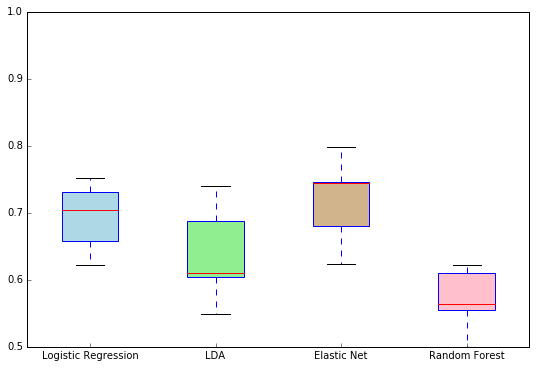

In [32]:
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
box = ax.boxplot(res, patch_artist=True)
colors = ['lightblue', 'lightgreen', 'tan', 'pink']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
ax.set_xticklabels(['Logistic Regression', 'LDA', 'Elastic Net', 'Random Forest'])
## Remove top axes and right axes ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_ylim(0.5, 1)

plt.show()

There is some prediction power without feature selection for az vs rest using linear models (logistic regression and elastic net)!! Now.. Let's see if I can improve this..

# 3. Perform feature selection based on DEGs

## 3.1 Feature selection

In [33]:
# output training data for limma input in R
X_tmp = pd.DataFrame.sort_index(X_train)
pd.DataFrame.to_csv(X_tmp,"fpkm_mrna.csv")
mrnaclin2 = mrnaclin[mrnaclin.index.isin(list(X_train.index))]
mrnaclin2 = pd.DataFrame.sort_index(mrnaclin2)
pd.DataFrame.to_csv(mrnaclin2[['pmi','apoe_genotype','cogdx']],"mrna_clin.csv")

In [34]:
import os
os.system("R CMD BATCH run_limma.R")

0

## 3.2 PCA and LDA

In [35]:
degs = open("fpkm_log2_mrna_deg_fdr0.05.txt", "r").read().split('\n')
del degs[-1] # remove last empty character caused by spliting
mrna_degs = mrna_yesvar.T[mrna_yesvar.T.index.isin(list(degs))]
len(mrna_degs.columns)
pd.DataFrame.to_csv(mrna_degs,"fpkm_mrna_degs.csv")

In [36]:
X = pd.DataFrame.as_matrix(mrna_degs.T)
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
lda = LDA(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

explained variance ratio (first two components): [ 0.90177627  0.04518235]


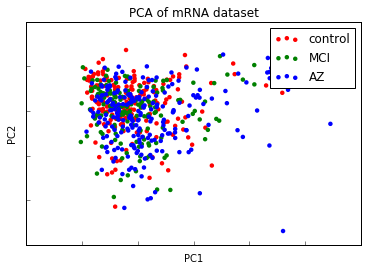

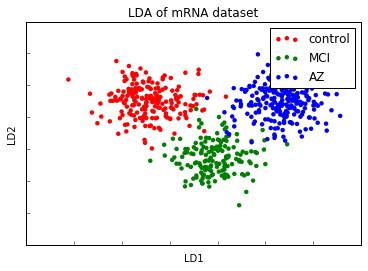

In [37]:
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

fig = plt.figure()
ax = fig.add_subplot(111)
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=c, edgecolor='', label=target_name)
plt.legend()
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of mRNA dataset')
fig.savefig('mRNA_degs_PCA.jpg', bbox_inches='tight', dpi=700)

fig = plt.figure()
ax = fig.add_subplot(111)
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], c=c, edgecolor='', label=target_name)
plt.legend()
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('LDA of mRNA dataset')
fig.savefig('mRNA_degs_LDA.jpg', bbox_inches='tight', dpi=700)

plt.show()

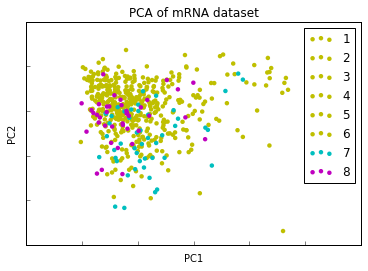

In [38]:
batch_names = np.array(["1","2","3","4","5","6","7","8"])
fig = plt.figure()
ax = fig.add_subplot(111)
for c, i, batch_name in zip("yyyyyycm", [1, 2, 3, 4, 5, 6, 7, 8], batch_names):
    plt.scatter(X_r[y2 == i, 0], X_r[y2 == i, 1], c=c, edgecolor='', label=batch_name)
plt.legend()
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of mRNA dataset')
fig.savefig('mRNA_degs_PCA.batch.jpg', bbox_inches='tight', dpi=700)

## 3.3 Prediction after feature selection (DEGs)

In [39]:
X_train = X_train.loc[:,degs]
X_test = X_test.loc[:,degs]

In [40]:
# Random Forest
params = [{'n_estimators': [10,50,100,200,300,400,500,1000]}]
rf = GridSearchCV(RandomForestClassifier(), params, cv =slo, scoring='roc_auc')
rf.fit(X_train, y_train)
rf = rf.best_estimator_
print("Random Forest accuracy = {}".format(rf.score(X_test,y_test)))

Random Forest accuracy = 0.683760683761


In [41]:
rf.n_estimators

400

In [42]:
rf_score = rf.predict_proba(X_test)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test,rf_score[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)
rf_roc_auc

0.67916666666666659

In [43]:
# Elastic Net
params = [{'l1_ratio': [0,0.25,0.5,0.75,1], 'alpha': [0.01,0.1,1,10,100,1000]}]
el = GridSearchCV(ElasticNet(), params, cv = slo, scoring='roc_auc')
el.fit(X_train, y_train)
el = el.best_estimator_
print("Elastic Net accuracy = {}".format(el.score(X_test,y_test)))

Elastic Net accuracy = 0.191867847069


/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:454: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)


In [44]:
print(el.l1_ratio)
print(el.alpha)

0.25
1


In [45]:
el_score = el.decision_function(X_test)
el_fpr, el_tpr, el_thresholds = roc_curve(y_test,el_score)
el_roc_auc = auc(el_fpr, el_tpr)
el_roc_auc

/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function decision_function is deprecated;  and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


0.7617283950617284

In [46]:
# LDA
params = [{'solver': ['svd','lsqr']}]
lda = GridSearchCV(LDA(), params, cv=slo, scoring='roc_auc')
lda.fit(X_train, y_train)
lda = lda.best_estimator_
print("LDA accuracy = {}".format(lda.score(X_test,y_test)))

LDA accuracy = 0.615384615385


In [47]:
lda.solver

'svd'

In [48]:
lda_score = lda.decision_function(X_test)
lda_fpr, lda_tpr, lda_thresholds = roc_curve(y_test,lda_score)
lda_roc_auc = auc(lda_fpr, lda_tpr)
lda_roc_auc

0.62469135802469133

In [49]:
# Logistic Regression
params = [{'solver': ['newton-cg','lbfgs','liblinear','sag']}]
lr = GridSearchCV(LogisticRegression(), params, cv=slo, scoring='roc_auc')
lr.fit(X_train, y_train)
lr = lr.best_estimator_
print("Logistic Regression accuracy = {}".format(lr.score(X_test,y_test)))

/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/utils/optimize.py:200: UserWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Logistic Regression accuracy = 0.666666666667


In [50]:
lr.solver

'lbfgs'

In [51]:
lr_score = lr.decision_function(X_test)
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test,lr_score)
lr_roc_auc = auc(lr_fpr, lr_tpr)
lr_roc_auc

0.71728395061728389

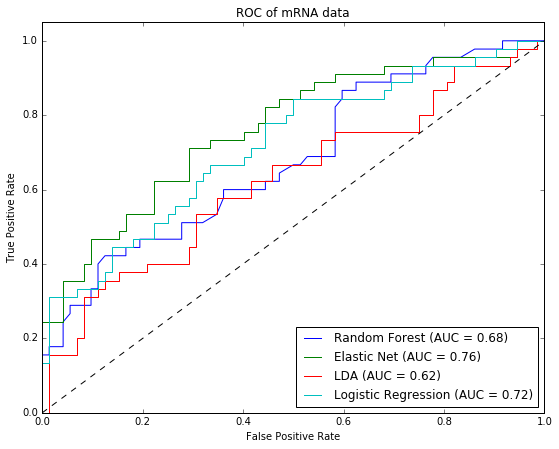

In [52]:
# Plot ROC curve
fig = plt.figure(1, figsize=(9, 7))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = %0.2f)' % rf_roc_auc)
plt.plot(el_fpr, el_tpr, label='Elastic Net (AUC = %0.2f)' % el_roc_auc)
plt.plot(lda_fpr, lda_tpr, label='LDA (AUC = %0.2f)' % lda_roc_auc)
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (AUC = %0.2f)' % lr_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of mRNA data')
plt.legend(loc="lower right")

fig.savefig('RNA-seq_DEG.ROC.jpg', bbox_inches='tight')
plt.show()